## Imports

/Users/juliano.garcia/miniconda3/envs/mlexp/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


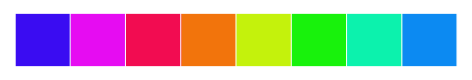

In [1]:
import toolz as fp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 50)
palette = sns.hls_palette(8, h=.7, s=.9, l=0.5)
sns.palplot(palette)
sns.set_palette(palette)

gray = "444444"

plt.rcParams['figure.facecolor'] = '1'  # background color
plt.rcParams['axes.facecolor'] = '1'  # plot background color

plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4

plt.rcParams['axes.edgecolor'] = '1'

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.linestyle'] = '-'

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray

plt.rcParams['text.color'] = gray

plt.rcParams['xtick.color'] = gray
plt.rcParams['ytick.color'] = gray
sns.set_style("whitegrid")

# Claimed Results

These results were posted in a forum about the game. They assume a discrete uniform distribution for every run of the game.
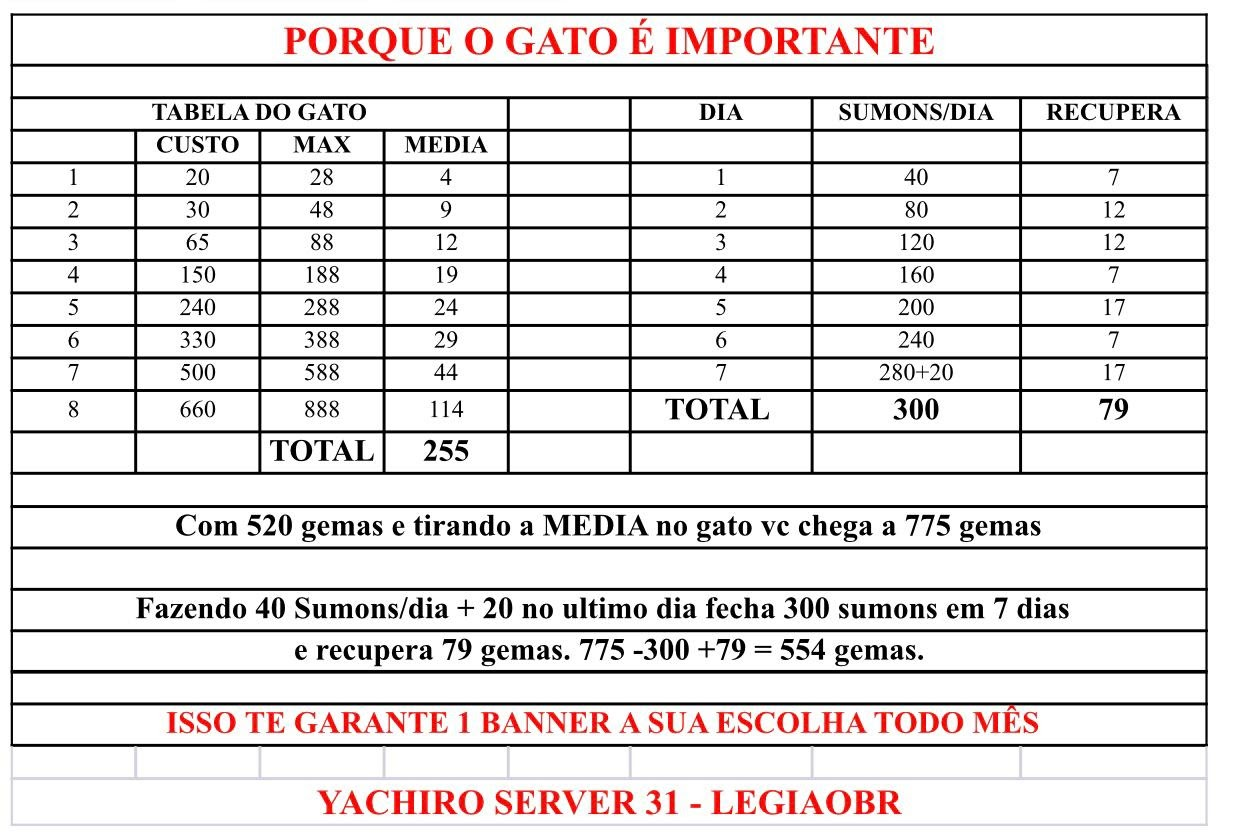

# The family of distributions we'll be using is the [Beta binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution)!

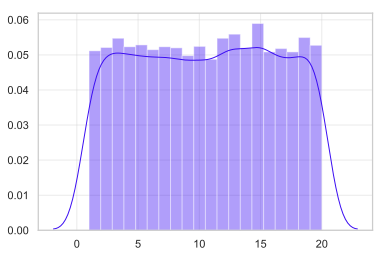

In [2]:
## showing what type of distribution we'll be using, example with maximum of 20
from scipy import stats
np.random.seed(42)
sampled_betabinom = stats.betabinom.rvs(n=19, a=1, b=1, size=10000) + 1
sns.distplot(sampled_betabinom, bins=20)

In [3]:
max(sampled_betabinom), min(sampled_betabinom), np.mean(sampled_betabinom)

(20, 1, 10.5412)

> Different cenarios for the fortune cat true distribution assume an unequal distribution, moving the PDF towards low reward values

Text(0.5, 1.0, 'All hypothesis for BB(a, 1, 19) + 1')

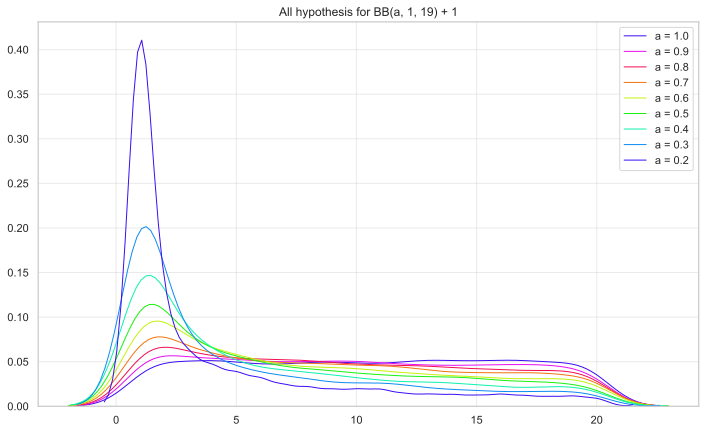

In [13]:
plt.subplots(figsize=(10, 6))
for x in range(9):
    sns.kdeplot(stats.betabinom.rvs(n=19, a=1 - x/10, b=1, size=10000) + 1, label=f"a = {round(1 - x/10, 2)}")
plt.tight_layout()
plt.title("All hypothesis for BB(a, 1, 19) + 1")

# Building simulation objects

In [5]:
@fp.curry
def betabinom_adj(a, b, n, size):
    return stats.betabinom.rvs(a=a, b=b, n=n, size=size) + 1

In [6]:
fortune_cat_dict = dict(
    cost_20 = betabinom_adj(n=7, b=1),
    cost_30 = betabinom_adj(n=17, b=1),
    cost_65 = betabinom_adj(n=22, b=1),
    cost_150 = betabinom_adj(n=37, b=1),
    cost_240 = betabinom_adj(n=47, b=1),
    cost_330 = betabinom_adj(n=57, b=1),
    cost_500 = betabinom_adj(n=87, b=1),
    cost_660 = betabinom_adj(n=227, b=1)
)

In [7]:
max_modifier = 10
distribution_modifier = 0
## we get the expected mean as stated from the table
fp.valmap(lambda v: np.mean(v(a=1 - distribution_modifier / max_modifier, size=10000)), fortune_cat_dict)

{'cost_20': 4.4807,
 'cost_30': 9.4153,
 'cost_65': 11.9674,
 'cost_150': 19.6421,
 'cost_240': 24.5354,
 'cost_330': 29.5611,
 'cost_500': 44.4558,
 'cost_660': 114.2451}

Sum of the individual means

In [8]:
np.sum(list(fp.valmap(lambda v: np.mean(v(a=1 - distribution_modifier / 10, size=10000)), fortune_cat_dict).values()))

258.73380000000003

# Simulation of all scenarios

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF
from functools import reduce

all_ecdfs, all_sums_outcomes = [], []
for distribution_modifier in range(max_modifier):
    current_dist_a = 1 - distribution_modifier / max_modifier
    print(f"Simulating sum of beta-binomial({round(current_dist_a, 2)}, 1)...")
    sum_of_all_gems_outcome = reduce(
        lambda x, y: x + y, fp.valmap(lambda v: v(a=current_dist_a, size=10000), fortune_cat_dict).values()
    )
    all_sums_outcomes.append((current_dist_a, sum_of_all_gems_outcome))
    ecdf_fn = ECDF(sum_of_all_gems_outcome)
    curr_dist_ecdf = ecdf_fn(np.sort(sum_of_all_gems_outcome))
    all_ecdfs.append((1 - ecdf_fn(255), np.sort(sum_of_all_gems_outcome), curr_dist_ecdf))

Simulating sum of beta-binomial(1.0, 1)...
Simulating sum of beta-binomial(0.9, 1)...
Simulating sum of beta-binomial(0.8, 1)...
Simulating sum of beta-binomial(0.7, 1)...
Simulating sum of beta-binomial(0.6, 1)...
Simulating sum of beta-binomial(0.5, 1)...
Simulating sum of beta-binomial(0.4, 1)...
Simulating sum of beta-binomial(0.3, 1)...
Simulating sum of beta-binomial(0.2, 1)...
Simulating sum of beta-binomial(0.1, 1)...


Text(0.5, 1.0, 'KDE of sum of outcomes')

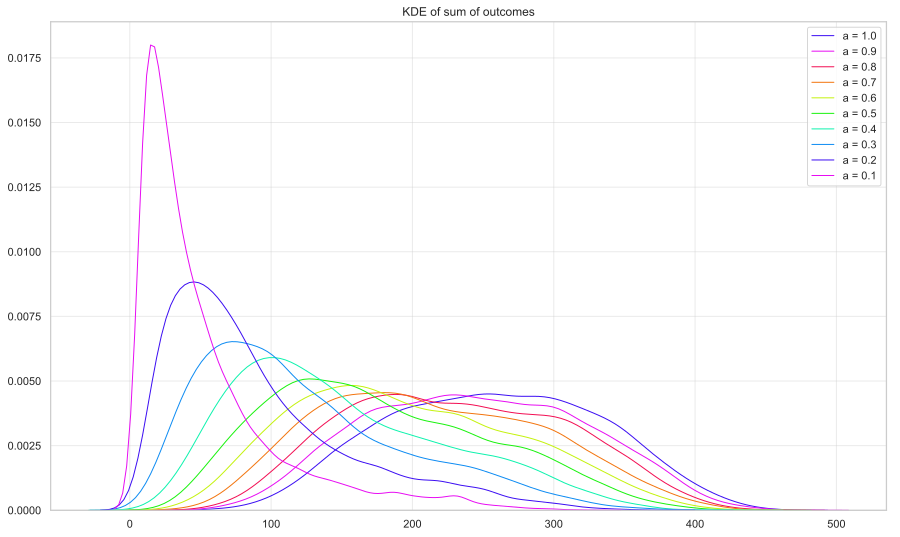

In [10]:
plt.subplots(figsize=(15, 9))
for curr_a, sum_rvs in all_sums_outcomes:
    sns.distplot(sum_rvs, hist=False, label=f"a = {round(curr_a, 2)}")
plt.title("KDE of sum of outcomes")

Text(0.5, 1.0, 'Cumulative Distribution for different fortune cat hypothesis')

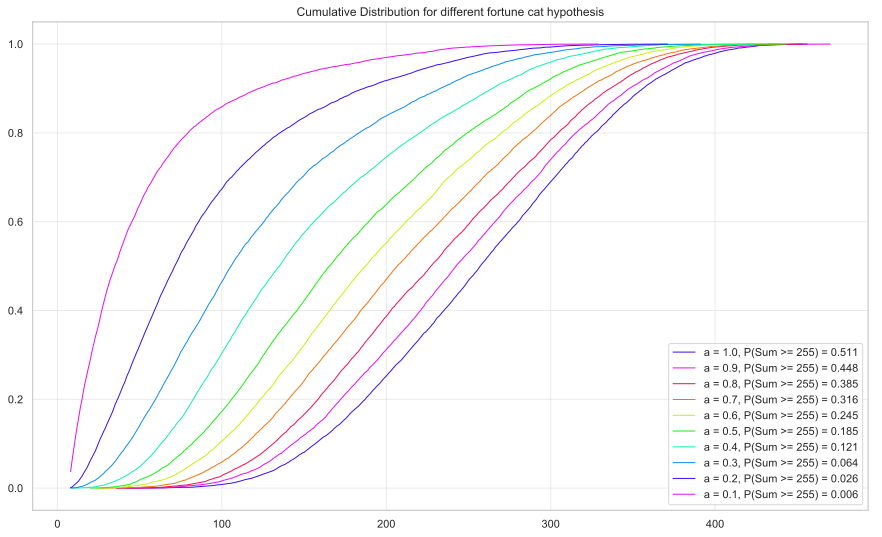

In [11]:
plt.subplots(figsize=(15, 9))
for (cdf_mean, x, y), (a, _) in zip(all_ecdfs, all_sums_outcomes):
    sns.lineplot(x, y, ci=None, label=f"a = {round(a, 2)}, P(Sum >= 255) = {round(cdf_mean, 3)}")
plt.title("Cumulative Distribution for different fortune cat hypothesis")

Just a small shift in the individual distributions (e.g. `a = 0.7`) can reduce in 20% the chance of getting >= 255 gems. Further distortions in the individual distributions could lead to an even lower chance of `outcome >= 255`, without making it very easy for the player to distinguish that the mechanics are skewed. Individually, it might be difficult for one to extrapolate from the individual distributions to the distribution of the sum of each run, making it even easier for the game designer to skew the distributions at will.